---
# EDA & Feature Extraction of the Reduced Dataset
---

In this notebook, the main aim was to study the dataset with exploratory data analysis, combined with the feature extraction phase for the reduced dataset (only 10 classes). 


## Libraries

In [55]:
import os 
import sys
import json 

from   random                    import sample
from   datetime                  import date

import pandas            as pd
import numpy             as np 
import matplotlib.pyplot as plt  
import seaborn           as sns
from   matplotlib.legend_handler import HandlerTuple

from   scipy.io                  import wavfile
from   python_speech_features    import mfcc, logfbank
import wave 
import librosa 

import cProfile    
from   tqdm                      import tqdm
from   IPython                   import display

In [3]:
sys.path.append('../src/features')
import feature_utils   as fs

sys.path.append('../src/data')
import data_utils      as ds
import constants

sys.path.append('../src/models')
import training_utils  as ts

## Graphic Settings

In [4]:
def set_dark_theme(figsize=(8, 8),
                   dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)

In [5]:
set_dark_theme()

## Common Filepaths between reduced and complete data

In [6]:
# Destination Path of the extracted .json file
JSON_PATH = "../data/processed/"

# Destination Path of .npy file
BINARIES_PATH = "../data/binaries/"

# Data Documentation path
DATA_DOCUMENTATION_PATH = "../data/raw/data_documentation/"

# Setting the default sample rate of 1 second file for the librosa library§
SAMPLES_TO_CONSIDER = 16000 

---
# Reduced Dataset
---

## Paths 

In [7]:
# N.B. The way the mfcc_feature_extraction function is defined assumes that the data folder 
# should contain only the sub-folders of labeled wav files 
REDUCED_DATASET_PATH = "../data/raw/dataset_v2_reduced/"

# name of the .json file 
REDUCED_JSON_NAME = "mfcc_v2_reduced_f_2022-05-23.json" # v2 is for the second version dataset - reduced is for only 10 classes - f is for filtered from short audio files - date of extraction

## Preliminary EDA phase

### Checking for audio files shorter than 1s 

In [8]:
%%time 
short_audio_samples, short_audio_distribution, audio_distribution, total_audio_files = ds.length_sanity_check(REDUCED_DATASET_PATH, verbosity = 1)
display.clear_output(wait=True)

CPU times: total: 14.8 s
Wall time: 2min 56s


### Saving names of short audio samples in a .txt file

In [9]:
textfile = open("../documents/short_audio_filenames_reduced.txt", "w")

for element in short_audio_samples:
    textfile.write(element + "\n")
    
textfile.close()

## Descriptive Statistics of compliant and non-compliant Data

#### Number of short files

In [10]:
f"{len(short_audio_samples)} of short audio samples"

'3571 of short audio samples'

#### Total number of files

In [11]:
f"{total_audio_files} total audio samples for 10 classes" 

'38547 total audio samples for 10 classes'

#### Fraction of short files

In [12]:
f"We got approximately {round(len(short_audio_samples)/total_audio_files*100,2)}% of short audio files"

'We got approximately 9.26% of short audio files'

#### Percentages of short samples per category

In [13]:
percentages_of_short_samples_per_category = {}

print("Category \t total files \t short files \t percentage of short files \n")

for category in short_audio_distribution.keys():     
    percentages_of_short_samples_per_category[category] = short_audio_distribution[category]/audio_distribution[category]*100    
    print(f"{category:15s} \t {audio_distribution[category]} \t\t {short_audio_distribution[category]} \t {percentages_of_short_samples_per_category[category]}\n")

Category 	 total files 	 short files 	 percentage of short files 

down            	 3918 		 338 	 8.626850433894845

go              	 3881 		 403 	 10.383921669672764

left            	 3802 		 300 	 7.890583903208838

no              	 3942 		 397 	 10.071029934043633

off             	 3746 		 319 	 8.515750133475708

on              	 3846 		 375 	 9.750390015600624

right           	 3779 		 331 	 8.758930934109554

stop            	 3873 		 310 	 8.004131164471985

up              	 3724 		 455 	 12.218045112781954

yes             	 4045 		 353 	 8.726823238566132



#### Display Absolute Frequencies of Categories

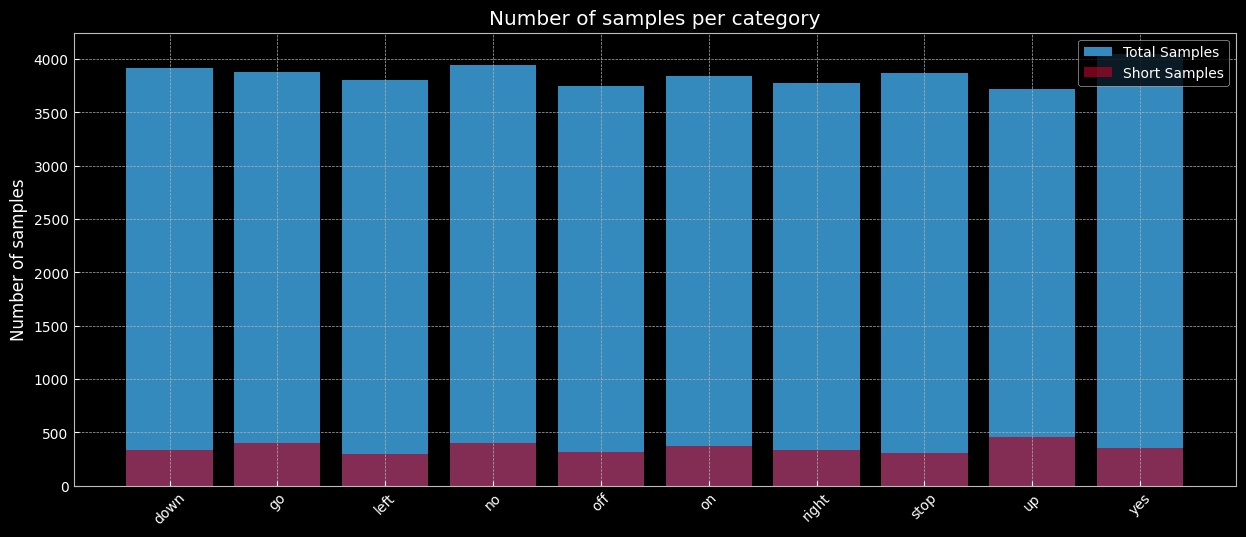

In [14]:
plt.figure(figsize = (15,6))

plt.bar(range(len( list(audio_distribution.keys()))) , list(audio_distribution.values()), label = "Total Samples")

plt.title("Number of samples per category")
plt.xticks(range(len(list(audio_distribution.keys()))), audio_distribution.keys(), rotation = 45)
plt.ylabel("Number of samples")

plt.bar(range(len( list(short_audio_distribution.keys()))) , list(short_audio_distribution.values()), label = "Short Samples", alpha = 0.7)

plt.legend()
plt.show()

Distribution of the classes is approximately uniform, both for the compliant and short audio files. 

#### Sample Mean, Median and Standard Deviation of # of short samples 

In [15]:
data_items = short_audio_distribution.items()
data_list = list(data_items)
short_audio_distribution_df = pd.DataFrame(data_list, columns = ["categories","absolute_frequency"])

In [16]:
short_audio_distribution_df.describe().T

,count,mean,std,min,25%,50%,75%,max
absolute_frequency,10.0,358.1,48.974937,300.0,322.0,345.5,391.5,455.0


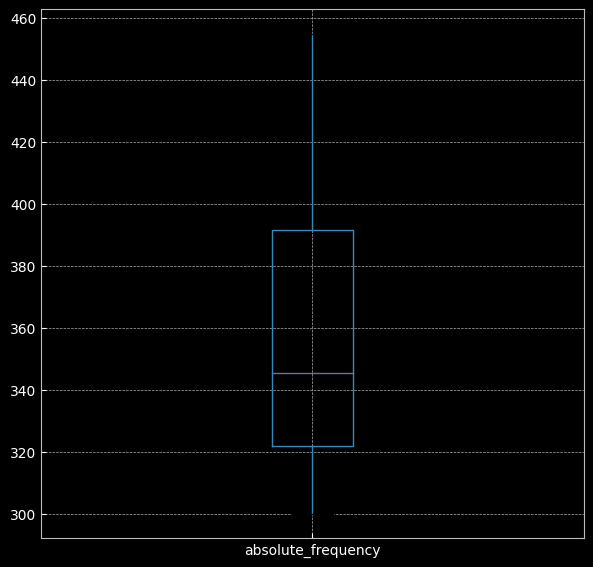

In [17]:
short_audio_distribution_df.boxplot(figsize = (7,7));

##  Analysis of audio quality 
Here we do extract 10 random audio traces per category from the training data, excluding files that are shorter than 1s. 

In [18]:
demo_sample_audio, demo_sample_names  = ds.extract_random_audio(dataset_path = REDUCED_DATASET_PATH, 
                                                                documentation_filename = "../documents/audio_filenames_train_reduced.txt" , 
                                                                file_amount = 10, 
                                                                save = False)

Executed on 2022-06-10


### "Down" Word

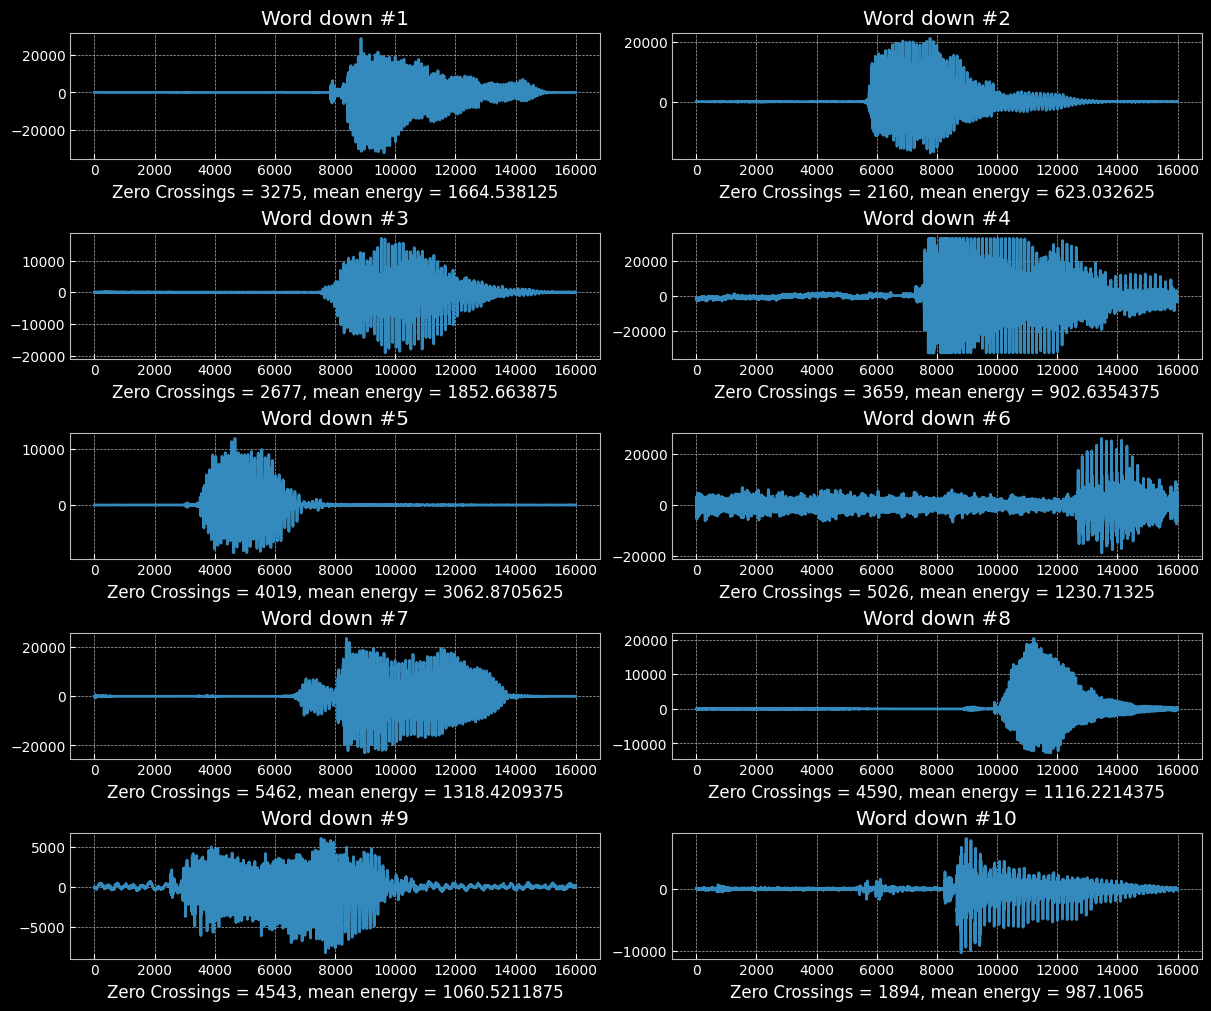

In [19]:
fig, axs = plt.subplots(5, 2, figsize = (12,10), constrained_layout = True)
counter = 0

for i in range(5):
    
    for j in range(2):
        
        # Raw Signal
        file = demo_sample_audio[category][counter]
        axs[i,j].plot(demo_sample_audio["down"][counter])
        axs[i,j].set_title(f"Word down #{counter+1}")
        
        # Zero Crossings
        zc_value = librosa.zero_crossings(file)
        zc_feature = np.sum(zc_value)
        
        axs[i,j].set(xlabel=f"Zero Crossings = {zc_feature}, mean energy = {fs.energy(file, mean = True)}")
        counter += 1

In [20]:
display.Audio(demo_sample_audio["down"][5], rate = 16000)

### Importing all (compliant) training audio data 

In [21]:
if input("Do you want to use a random sample or to use all available data? sample/all:   ").lower() == "sample":
    
    compliant_audio_train, compliant_audio_names_train = ds.extract_random_audio(dataset_path = COMPLETE_DATASET_PATH, 
                                                                            documentation_filename = "../documents/audio_filenames_train_reduced.txt" , 
                                                                            file_amount = 100, 
                                                                            save = False)
    
else:
    
    compliant_audio_train, compliant_audio_names_train = ds.extract_audio(dataset_path = REDUCED_DATASET_PATH, 
                                                                     documentation_filename = "../documents/audio_filenames_train_reduced.txt",
                                                                     save = False)

Do you want to use a random sample or to use all available data? sample/all:    all


Executed on 2022-06-10


### Importing all (compliant) validation audio data 

In [22]:
if input("Do you want to use a random sample or to use all available data? sample/all:   ").lower() == "sample":
    
    compliant_audio_valid, compliant_audio_names_valid = ds.extract_random_audio(dataset_path = REDUCED_DATASET_PATH, 
                                                                            documentation_filename = "../documents/audio_filenames_valid_reduced.txt" , 
                                                                            file_amount = 100, 
                                                                            save = False)
    
else:
    
    compliant_audio_valid, compliant_audio_names_valid = ds.extract_audio(dataset_path = REDUCED_DATASET_PATH, 
                                                                     documentation_filename = "../documents/audio_filenames_valid_reduced.txt",
                                                                     save = False)

Do you want to use a random sample or to use all available data? sample/all:    all


Executed on 2022-06-10


### Importing all (compliant) test audio data 

In [23]:
if input("Do you want to use a random sample or to use all available data? sample/all:   ").lower() == "sample":
    
    compliant_audio_test, compliant_audio_names_test = ds.extract_random_audio(dataset_path = REDUCED_DATASET_PATH, 
                                                                            documentation_filename = "../documents/audio_filenames_test_reduced.txt" , 
                                                                            file_amount = 100, 
                                                                            save = False)
    
else:
    
    compliant_audio_test, compliant_audio_names_test = ds.extract_audio(dataset_path = REDUCED_DATASET_PATH, 
                                                                        documentation_filename = "../documents/audio_filenames_test_reduced.txt",
                                                                        save = False)

Do you want to use a random sample or to use all available data? sample/all:    all


Executed on 2022-06-10


### Importing all (non-compliant) audio data 

In [24]:
if input("Do you want to use a random sample or to use all available data? sample/all:   ").lower() == "sample":
    
    short_audio, short_audio_names = ds.extract_random_audio(dataset_path = REDUCED_DATASET_PATH, 
                                                             documentation_filename = "../documents/short_audio_filenames_reduced.txt", 
                                                             file_amount = 50, 
                                                             save = False)
else: 
    
    short_audio, short_audio_names = ds.extract_audio(dataset_path = REDUCED_DATASET_PATH, 
                                                      documentation_filename = "../documents/short_audio_filenames_reduced.txt", 
                                                      save = False)

Do you want to use a random sample or to use all available data? sample/all:    all


Executed on 2022-06-10


In [62]:
demo_sample_names["down"][0]

'down/1b755c65_nohash_0.wav'

## Audio features for quality check
###  Zero-Crossing & Zero Crossing Rate
The [zero crossing rate](https://en.wikipedia.org/wiki/Zero-crossing_rate) indicates the number of times that a signal crosses the horizontal axis in time. Also the zero crossings are extracted.


In [25]:
%%time 
#Train
zc_feature_train, zcr_feature_train = fs.zero_crossings(compliant_audio_train)
# Valid
zc_feature_valid, zcr_feature_valid = fs.zero_crossings(compliant_audio_valid)
#Test
zc_feature_test, zcr_feature_test   = fs.zero_crossings(compliant_audio_test)
# non-compliant audio files
zc_feature_short, zcr_feature_short = fs.zero_crossings(short_audio)

Executed on 2022-06-10
Executed on 2022-06-10
Executed on 2022-06-10
Executed on 2022-06-10
CPU times: total: 32.6 s
Wall time: 32.9 s


#### Comparing Zero Crossings Distributions across Categories - Empirical Probability Distribution of train compliant audio files and non-compliant 

We recall that zero crossing is a scalar value per each sample.

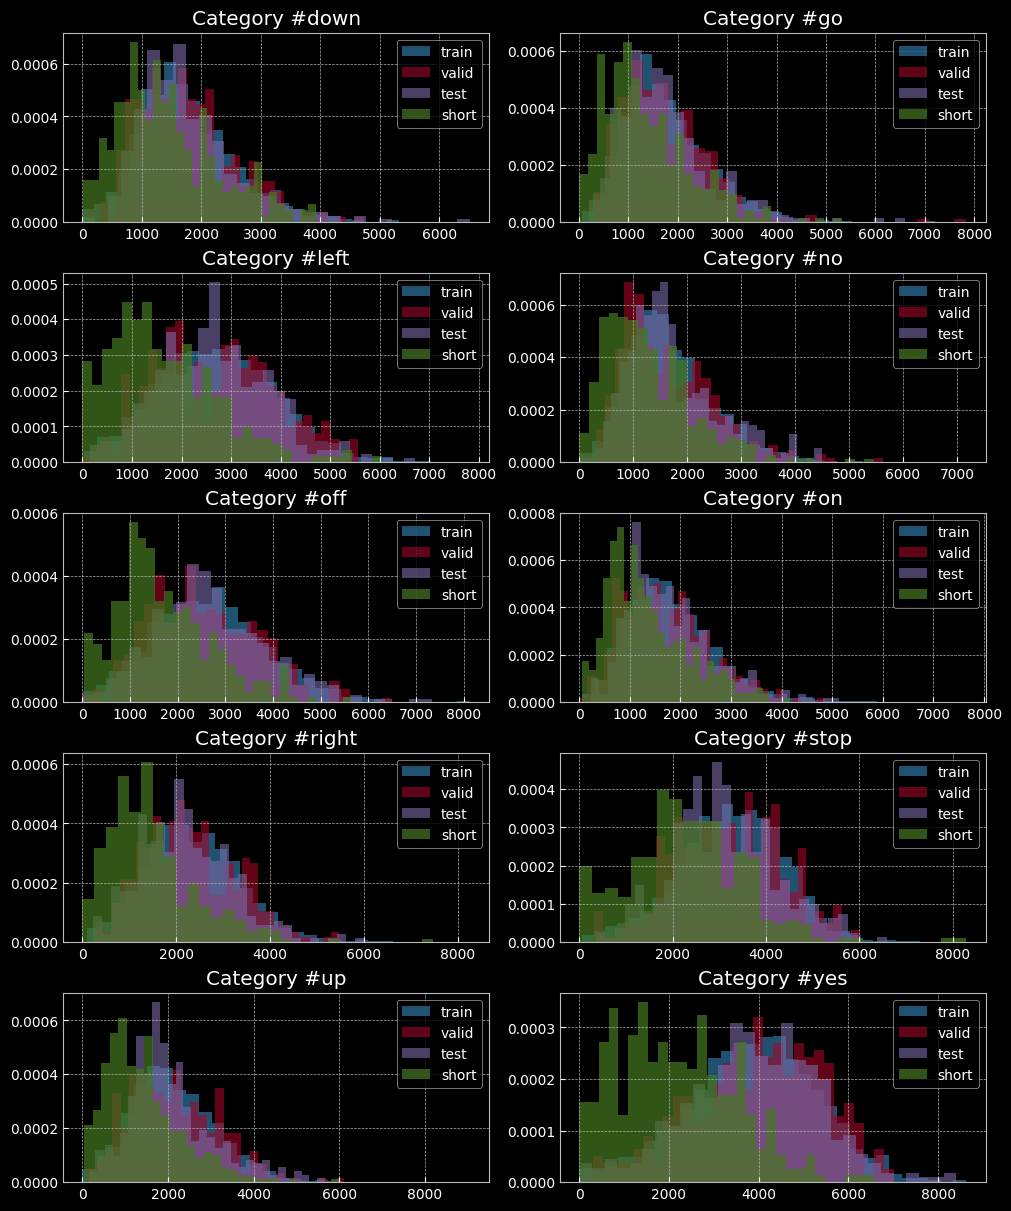

In [26]:
fig, axs = plt.subplots(5, 2, figsize = (10,12), constrained_layout = True)
categories = list(compliant_audio_train.keys())
counter = 0

for i in range(5):
    
    for j in range(2):
        
        axs[i,j].hist(zc_feature_train[categories[counter]], bins = 30, alpha=0.6, density = True, label = "train")
        axs[i,j].hist(zc_feature_valid[categories[counter]], bins = 30, alpha=0.6, density = True, label = "valid")
        axs[i,j].hist(zc_feature_test[categories[counter]],  bins = 30, alpha=0.6, density = True, label = "test")
        
        axs[i,j].hist(zc_feature_short[categories[counter]], bins = 30, alpha=0.7, density = True, label = "short")

        axs[i,j].legend(loc = "upper right")
        axs[i,j].set_title(f"Category #{categories[counter]}")
        
        counter += 1

#### Zero Crossing Rate 

This is the evolution over time of the zero crossings value, over a window of 512 samples (*frame size*) and an overlap of 256 samples. Here we display the zero crossing rate for just a single audio.

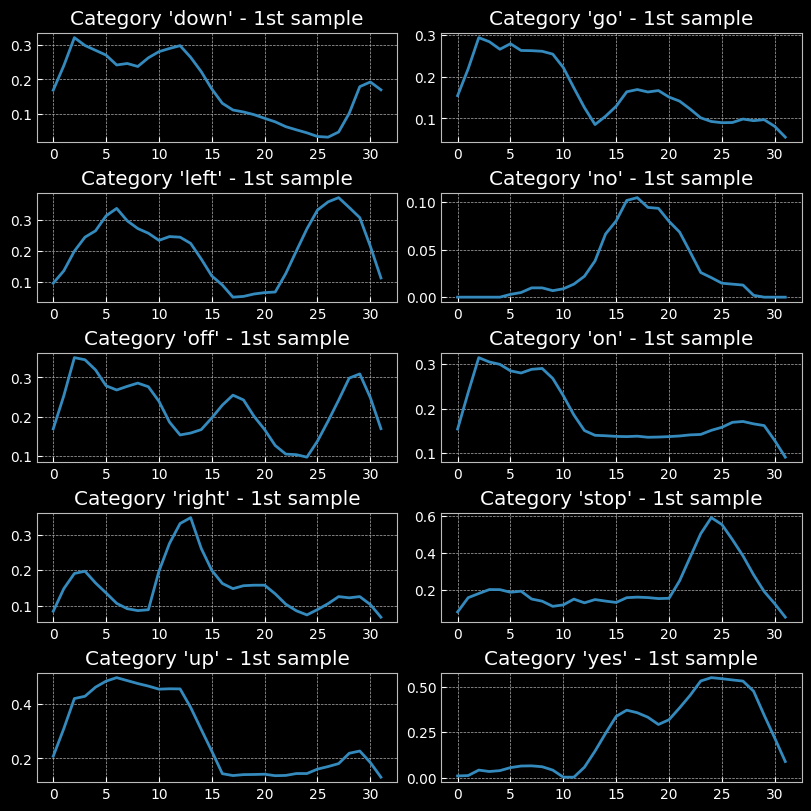

In [27]:
fig, axs = plt.subplots(5, 2, figsize = (8,8), constrained_layout = True)
categories = list(compliant_audio_train.keys())
counter = 0

for i in range(5):
    for j in range(2):
        axs[i,j].plot(zcr_feature_train[categories[counter]][0])
        axs[i,j].set_title(f"Category '{categories[counter]}' - 1st sample")
        # axs[i,j].xlabel("Spectral Centroid")
        counter += 1

### Spectral Centroid


The [spectral centroid](https://en.wikipedia.org/wiki/Spectral_centroid) is a measure used in digital signal processing to characterise a spectrum. It indicates where the center of mass of the spectrum is located. Perceptually, it has a robust connection with the impression of brightness of a sound. It is sometimes called center of spectral mass.
It is calculated as the weighted mean of the frequencies present in the signal, determined using a Fourier transform, with their magnitudes as the weights
$$centroid = \frac{\sum_{n=0}^{N-1}f(n)x(n)}{\sum_{n=0}^{N-1}x(n)}$$
where x(n) represents the weighted frequency value, or magnitude, of bin number n, and f(n) represents the center frequency of that bin.

From [librosa's documentation](http://librosa.org/doc/main/generated/librosa.feature.spectral_centroid.html):

"Each frame of a magnitude spectrogram is normalized and treated as a distribution over frequency bins, from which the mean (centroid) is extracted per frame.
More precisely, the centroid at frame $t$ is defined as:
$$centroid[t] = sum_k S[k, t] * freq[k] / (sum_j S[j, t])$$
where S is a magnitude spectrogram, and freq is the array of frequencies (e.g., FFT frequencies in Hz) of the rows of S."

In [28]:
spectral_centroid = {}

for category in compliant_audio_train.keys():

    spectral_centroid[category] = []

    for file in compliant_audio_train[category]:
        
        sc_value = librosa.feature.spectral_centroid(y = file.astype(np.float32), sr = 16000).T
        spectral_centroid[category] += [sc_value]

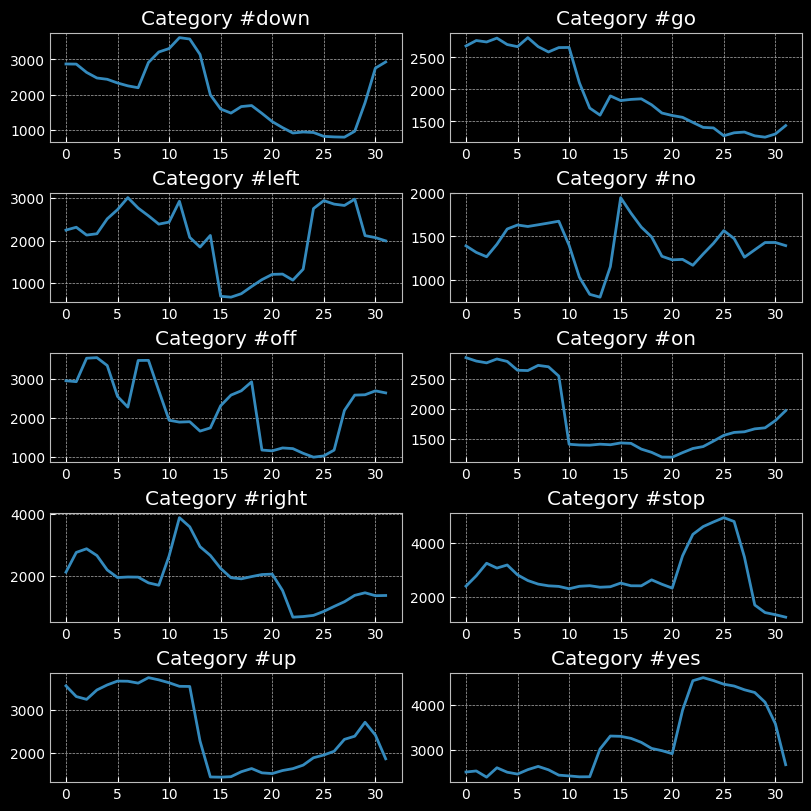

In [29]:
fig, axs = plt.subplots(5, 2, figsize = (8,8), constrained_layout = True)
counter, categories = 0, list(spectral_centroid.keys()) 

for i in range(5):
    for j in range(2):
        axs[i,j].plot(spectral_centroid[categories[counter]][0])
        axs[i,j].set_title(f"Category #{categories[counter]}")
        counter += 1

### Mean Energy
The **energy** ([Wikipedia](https://en.wikipedia.org/wiki/Energy_(signal_processing%29))) of a signal corresponds to the total magntiude of the signal. For audio signals, that roughly corresponds to how loud the signal is. The energy in a signal is defined as $ \sum_n \left| x(n) \right|^2 $.Mean energy is the energy of a signal divided by its length. Mean energy is the energy of a signal divided by its length.

In [30]:
%%time 
#Train
energies_feature_train = fs.mean_energies(compliant_audio_train)
# Valid
energies_feature_valid = fs.mean_energies(compliant_audio_valid)
#Test
energies_feature_test   = fs.mean_energies(compliant_audio_test)
# non-compliant audio files
energies_feature_short = fs.mean_energies(short_audio)

Executed on 2022-06-10
Executed on 2022-06-10
Executed on 2022-06-10
Executed on 2022-06-10
CPU times: total: 2.06 s
Wall time: 2.06 s


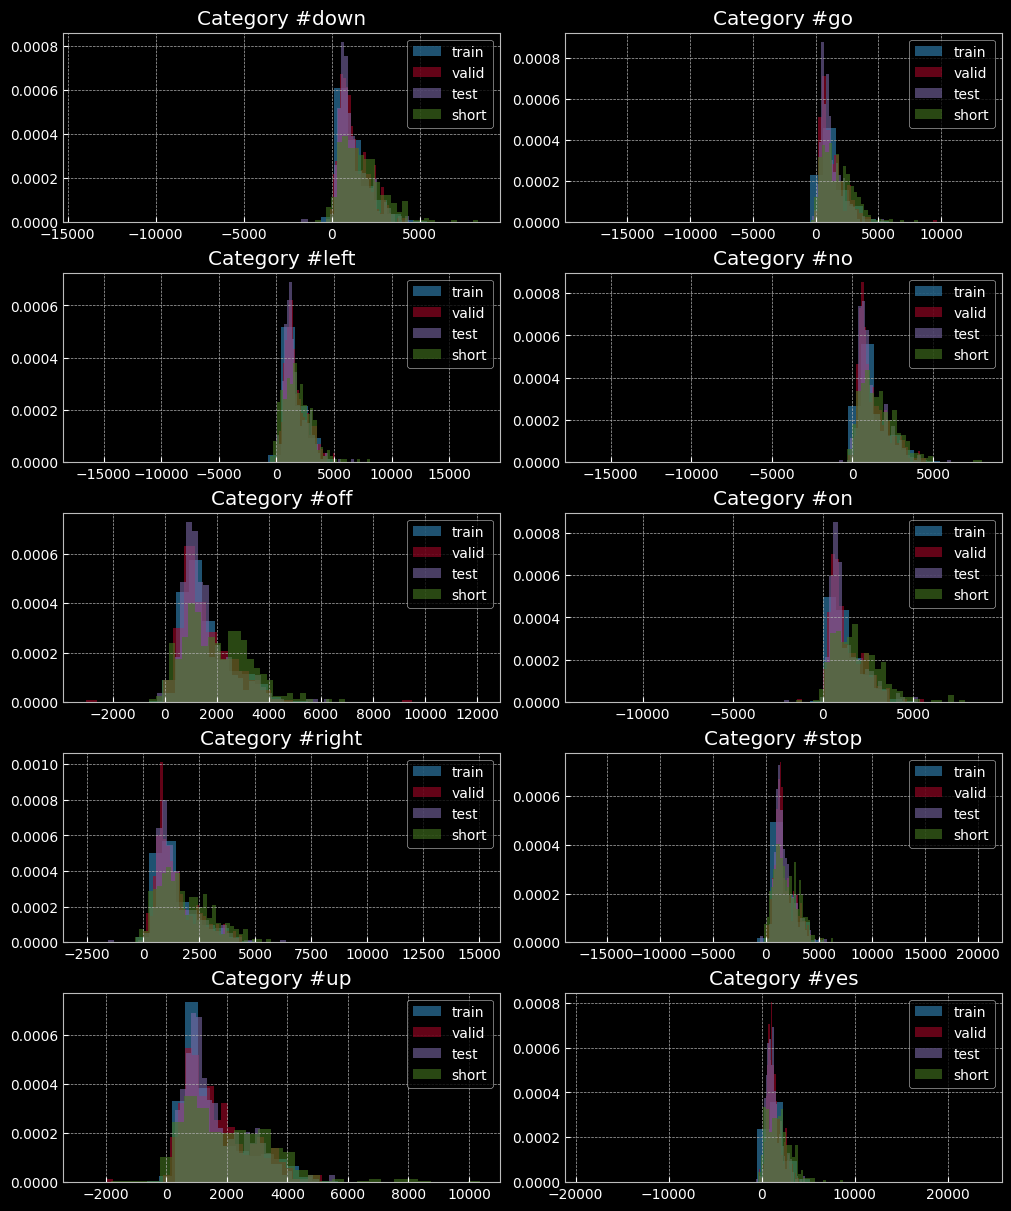

In [31]:
fig, axs = plt.subplots(5, 2, figsize = (10,12), constrained_layout = True)
categories = list(compliant_audio_train.keys())
counter = 0

for i in range(5):
    for j in range(2):
        
        axs[i,j].hist(energies_feature_train[categories[counter]], bins = 30, alpha=0.6, density = True, label = "train")
        axs[i,j].hist(energies_feature_valid[categories[counter]], bins = 30, alpha=0.6, density = True, label = "valid")
        axs[i,j].hist(energies_feature_test[categories[counter]],  bins = 30, alpha=0.6, density = True, label = "test")
        
        axs[i,j].hist(energies_feature_short[categories[counter]], bins = 30, alpha=0.6, density = True, label = "short")

        axs[i,j].legend(loc = "upper right")
        axs[i,j].set_title(f"Category #{categories[counter]}")
        
        counter += 1

Available Categories 
 ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']


Insert a category, if not press enter left
Insert a category, if not press enter 


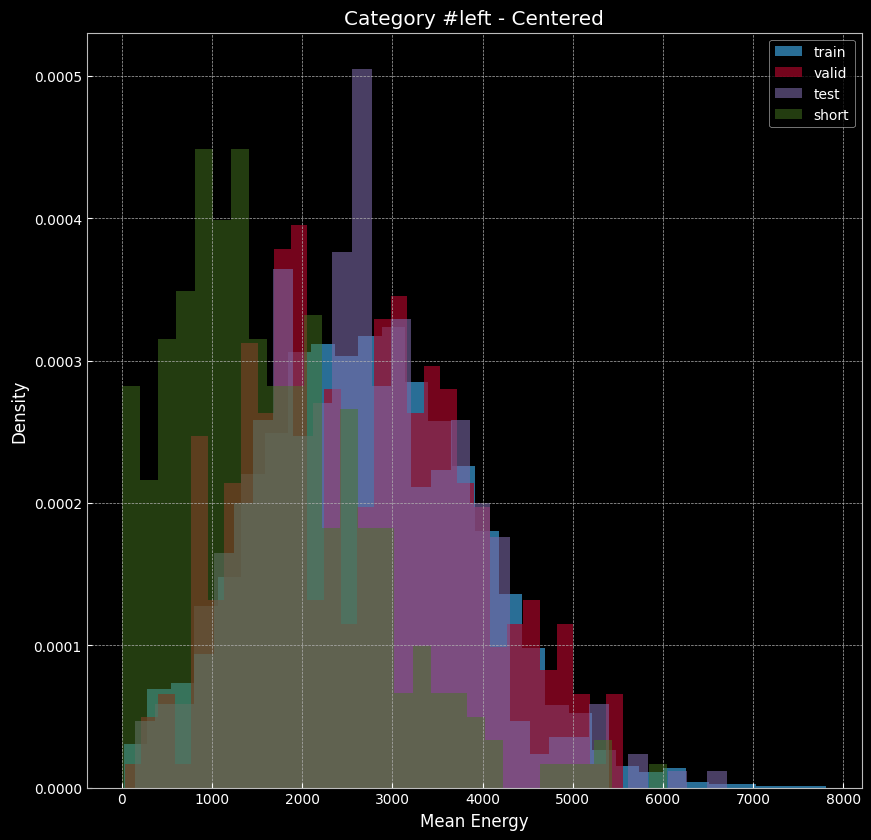

In [32]:
print("===========================================================================================")
reduced_classes = list(constants.labels_10_classes.keys())
print(f"Available Categories \n {reduced_classes}")
category = input("Insert a category, if not press enter")       

while category: 
    
    while category.lower() not in reduced_classes: 
        
        category = input("Wrong category insert a correct one ")  
        
    plt.figure(figsize = (10,10))
    
    plt.hist(zc_feature_train[category], bins = 30, alpha=0.8, density = True, label = "train")
    plt.hist(zc_feature_valid[category], bins = 30, alpha=0.7, density = True, label = "valid")
    plt.hist(zc_feature_test[category],  bins = 30, alpha=0.6, density = True, label = "test")

    plt.hist(zc_feature_short[category], bins = 30, alpha=0.5, density = True, label = "short")

    plt.legend(loc = "upper right")
    plt.title(f"Category #{category} - Centered")
    plt.xlabel(xlabel = "Mean Energy")
    plt.ylabel(ylabel = "Density")
    
    category = input("Insert a category, if not press enter")

## Finding human unclassifiable samples

To make such research we may do some consideration made on the preliminary analyses. 
This process could be time exhausting since to identify such files we may need a human being detect them. The alternative may rely on some temporal analysis' features, like the ones we considered before. 

Nonetheless, given a *signal* $x(n): n = 1, \dots, N$, the ones we want to use are: 
- *Length of the Signal* $\normalsize N$ 
- *Mean Energy* $\normalsize  \mathbf{\bar{E}}[x(n)] = \frac{\sum_{n=1}^{N}|x(n)|^2}{N}$  (the absolute value isn't necessary since we're not dealing with complex numbers here)
- *Scaled Zero Crossings* $\normalsize \operatorname{ZC}_{\text{scaled}}[x(n)] =  \frac{\sum_{n = 1}^{N - 1} \mathbf{1}_{\mathbf{R}_{<0}}(x(n)* x(n+1))}{N}$

To overcome some of the issues in the search of unuseful samples we shall center each signal.

### Centering

In [33]:
compliant_audio_train_centered, compliant_audio_valid_centered, compliant_audio_test_centered, short_audio_centered = {}, {}, {}, {} 

for category in compliant_audio_train.keys():
    
    # Training Data
    for file in compliant_audio_train[category]: 
        
        if category in compliant_audio_train_centered.keys():
            compliant_audio_train_centered[category] += [file-np.mean(file)]
        else: 
            compliant_audio_train_centered[category] = [file-np.mean(file)]
    # Validation Data 
    for file in compliant_audio_valid[category]: 
        
        if category in compliant_audio_valid_centered.keys():
            compliant_audio_valid_centered[category] += [file-np.mean(file)]
        else: 
            compliant_audio_valid_centered[category] = [file-np.mean(file)]
    # Test Data 
    for file in compliant_audio_train[category]: 
            
        if category in compliant_audio_test_centered.keys():
            compliant_audio_test_centered[category] += [file-np.mean(file)]
        else: 
            compliant_audio_test_centered[category] = [file-np.mean(file)]    
    # Short Data
    for file in short_audio[category]: 
        
        if category in short_audio_centered.keys():
            short_audio_centered[category] += [file-np.mean(file)]
        else: 
            short_audio_centered[category] = [file-np.mean(file)]        

### Scaled Zero Crossings on centered audio files

In [34]:
%%time 
#Train
zc_feature_train_centered = fs.zero_crossings(compliant_audio_train_centered,
                                              scaled = True,
                                              rate = False)
# Valid
zc_feature_valid_centered = fs.zero_crossings(compliant_audio_valid_centered, 
                                              scaled = True, 
                                              rate = False)
#Test
zc_feature_test_centered  = fs.zero_crossings(compliant_audio_test_centered,  
                                              scaled = True, 
                                              rate = False)
# non-compliant audio files
zc_feature_short_centered = fs.zero_crossings(short_audio_centered,
                                              scaled = True, 
                                              rate = False)

Executed on 2022-06-10
Executed on 2022-06-10
Executed on 2022-06-10
Executed on 2022-06-10
CPU times: total: 7.52 s
Wall time: 7.55 s


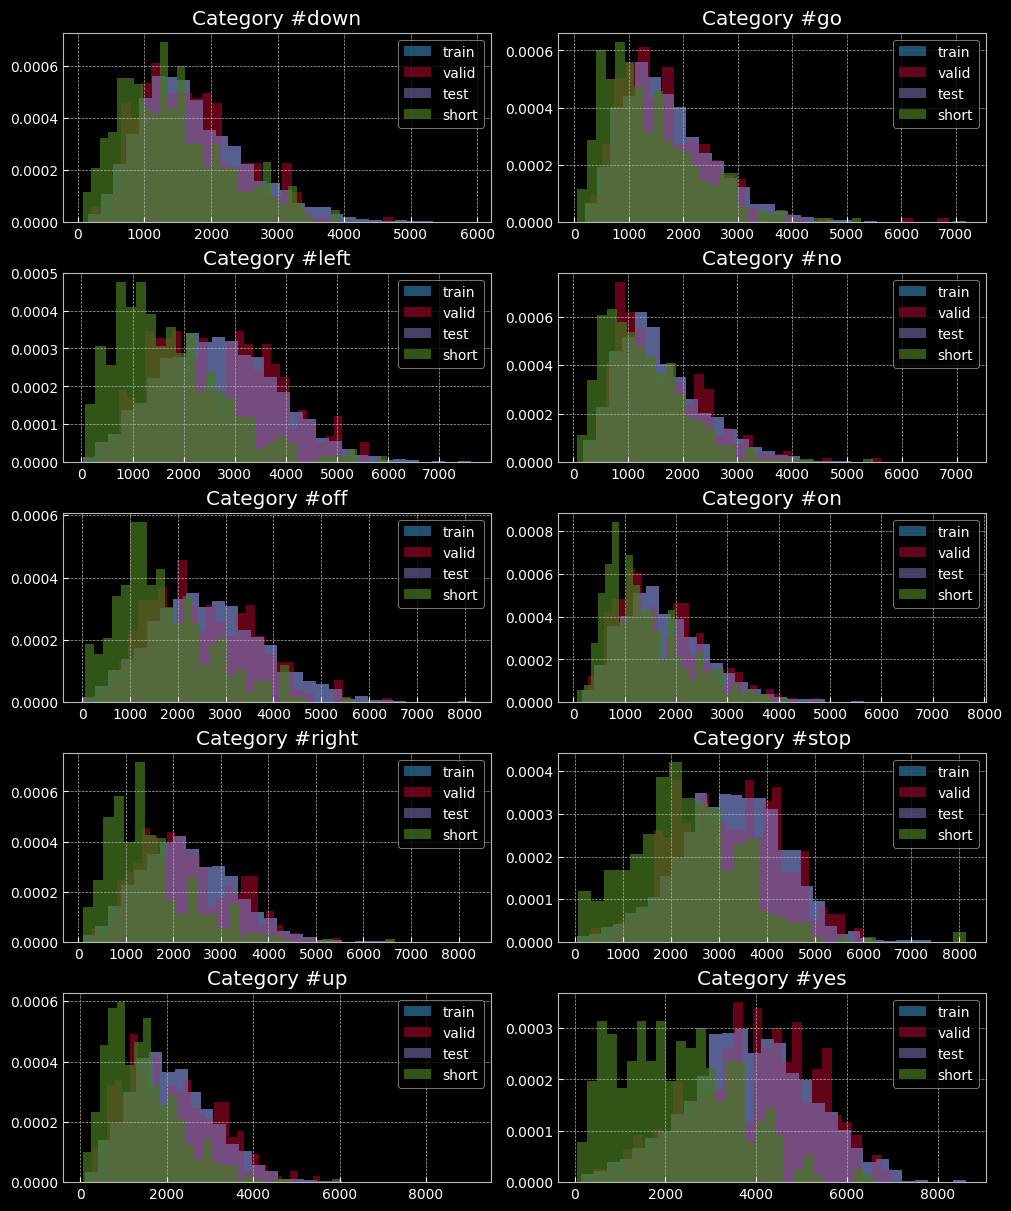

In [35]:
fig, axs = plt.subplots(5, 2, figsize = (10,12), constrained_layout = True)
categories = list(compliant_audio_train.keys())
counter = 0

for i in range(5):
    
    for j in range(2):
        
        axs[i,j].hist(zc_feature_train_centered[categories[counter]], bins = 30, alpha=0.6, density = True, label = "train")
        axs[i,j].hist(zc_feature_valid_centered[categories[counter]], bins = 30, alpha=0.6, density = True, label = "valid")
        axs[i,j].hist(zc_feature_test_centered[categories[counter]],  bins = 30, alpha=0.6, density = True, label = "test")
        
        axs[i,j].hist(zc_feature_short_centered[categories[counter]], bins = 30, alpha=0.7, density = True, label = "short")

        axs[i,j].legend(loc = "upper right")
        axs[i,j].set_title(f"Category #{categories[counter]}")
        
        counter += 1

Available Categories 
 ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']


Insert a category, if not press enter yes
Insert a category, if not press enter 


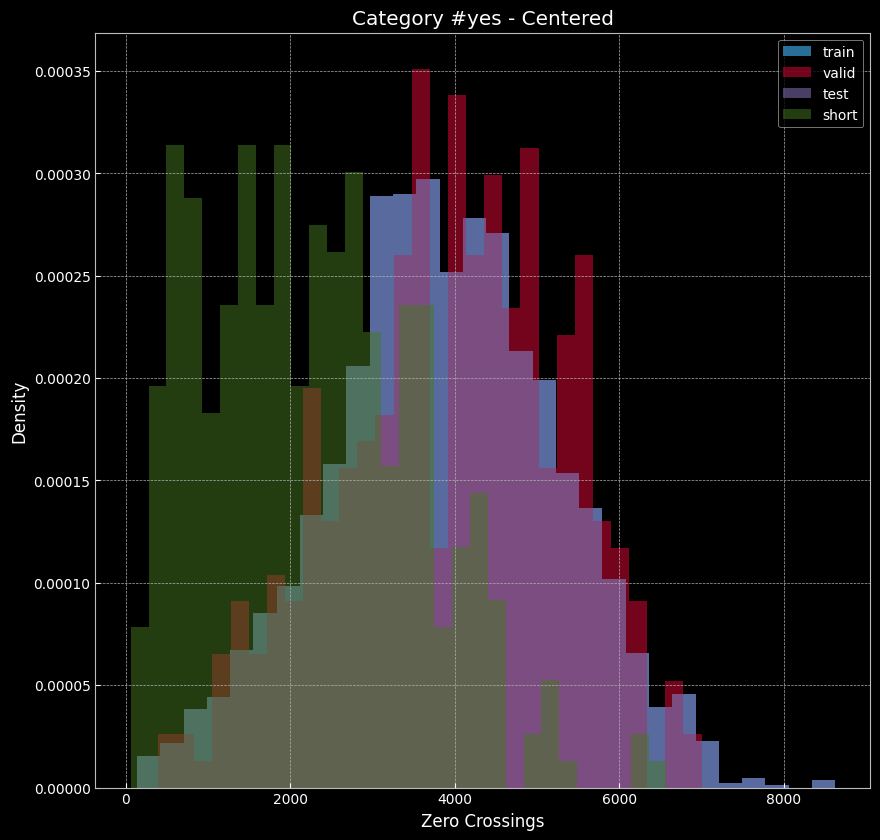

In [36]:
print("===========================================================================================")
reduced_classes = list(constants.labels_10_classes.keys())
print(f"Available Categories \n {reduced_classes}")
category = input("Insert a category, if not press enter")       

while category: 
    
    while category.lower() not in reduced_classes: 
        
        category = input("Wrong category insert a correct one ")  
        
    plt.figure(figsize = (10,10))
    
    plt.hist(zc_feature_train_centered[category], bins = 30, alpha=0.8, density = True, label = "train")
    plt.hist(zc_feature_valid_centered[category], bins = 30, alpha=0.7, density = True, label = "valid")
    plt.hist(zc_feature_test_centered[category],  bins = 30, alpha=0.6, density = True, label = "test")

    plt.hist(zc_feature_short_centered[category], bins = 30, alpha=0.5, density = True, label = "short")

    plt.legend(loc = "upper right")
    plt.title(f"Category #{category} - Centered")
    plt.xlabel(xlabel = "Zero Crossings")
    plt.ylabel(ylabel = "Density")
    
    category = input("Insert a category, if not press enter")

### Mean Energy on centered Audio files 


In [40]:
%%time 
#Train
energies_feature_train_centered = fs.mean_energies(compliant_audio_train_centered)
# Valid
energies_feature_valid_centered = fs.mean_energies(compliant_audio_valid_centered)
#Test
energies_feature_test_centered   = fs.mean_energies(compliant_audio_test_centered)
# non-compliant audio files
energies_feature_short_centered = fs.mean_energies(short_audio_centered)

Executed on 2022-06-10
Executed on 2022-06-10
Executed on 2022-06-10
Executed on 2022-06-10
CPU times: total: 2.39 s
Wall time: 2.4 s


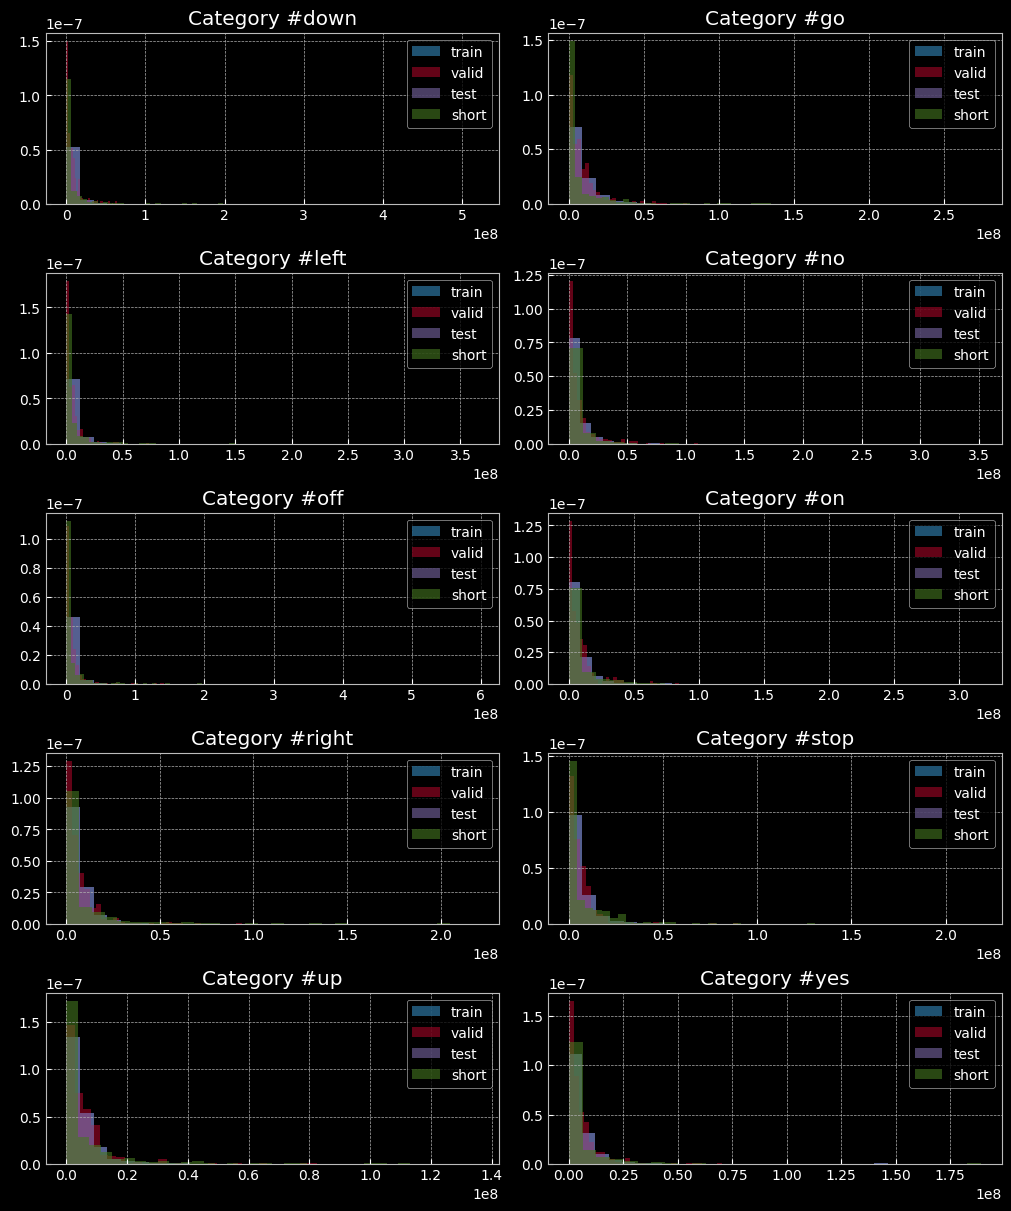

In [41]:
fig, axs = plt.subplots(5, 2, figsize = (10,12), constrained_layout = True)
categories = list(compliant_audio_train.keys())
counter = 0

for i in range(5):
    for j in range(2):
        
        axs[i,j].hist(energies_feature_train_centered[categories[counter]], bins = 30, alpha=0.6, density = True, label = "train")
        axs[i,j].hist(energies_feature_valid_centered[categories[counter]], bins = 30, alpha=0.6, density = True, label = "valid")
        axs[i,j].hist(energies_feature_test_centered[categories[counter]],  bins = 30, alpha=0.6, density = True, label = "test")
        
        axs[i,j].hist(energies_feature_short_centered[categories[counter]], bins = 30, alpha=0.6, density = True, label = "short")

        axs[i,j].legend(loc = "upper right")
        axs[i,j].set_title(f"Category #{categories[counter]}")
        
        counter += 1

Available Categories 
 ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']


Insert a category, if not press enter yes
Insert a category, if not press enter 


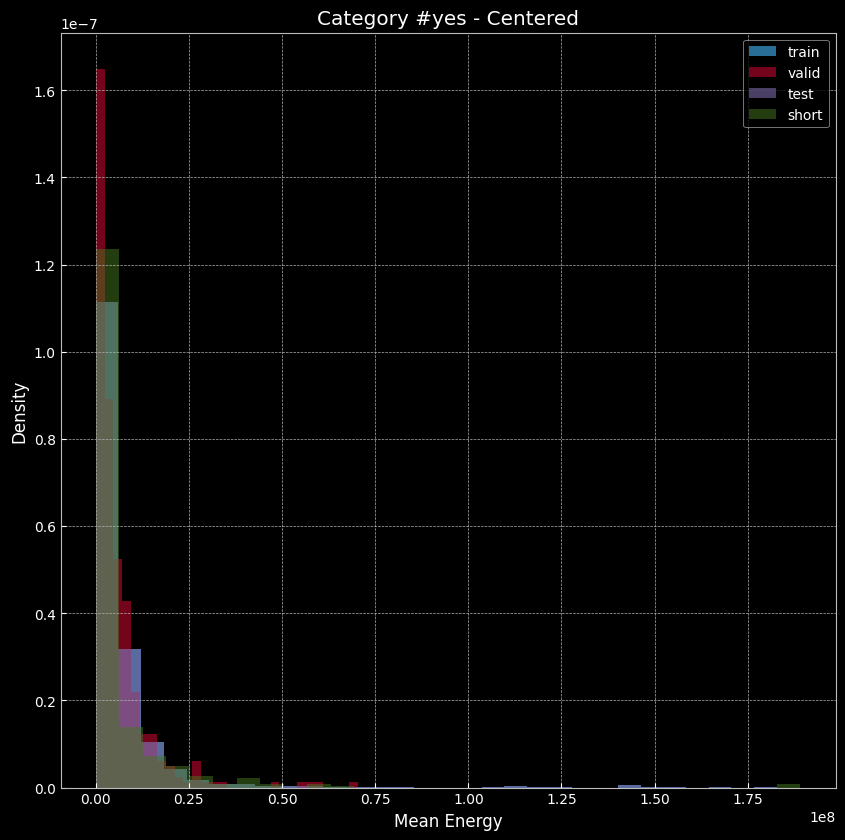

In [43]:
print("===========================================================================================")
reduced_classes = list(constants.labels_10_classes.keys())
print(f"Available Categories \n {reduced_classes}")
category = input("Insert a category, if not press enter")       

while category: 
    
    while category.lower() not in reduced_classes: 
        
        category = input("Wrong category insert a correct one ")  
        
    plt.figure(figsize = (10,10))
    
    plt.hist(energies_feature_train_centered[category], bins = 30, alpha=0.8, density = True, label = "train")
    plt.hist(energies_feature_valid_centered[category], bins = 30, alpha=0.7, density = True, label = "valid")
    plt.hist(energies_feature_test_centered[category],  bins = 30, alpha=0.6, density = True, label = "test")

    plt.hist(energies_feature_short_centered[category], bins = 30, alpha=0.5, density = True, label = "short")

    plt.legend(loc = "upper right")
    plt.title(f"Category #{category} - Centered")
    plt.xlabel(xlabel = "Mean Energy")
    plt.ylabel(ylabel = "Density")
    
    category = input("Insert a category, if not press enter")



### Distribution of $\normalsize \phi = (\mathbf{\bar{E}}[x(n)_{\text{ctd}}],  \operatorname{ZC}_{\text{scaled}}[x(n)_{\text{ctd}}])$



Would you prefer centered data features? y/n:   y


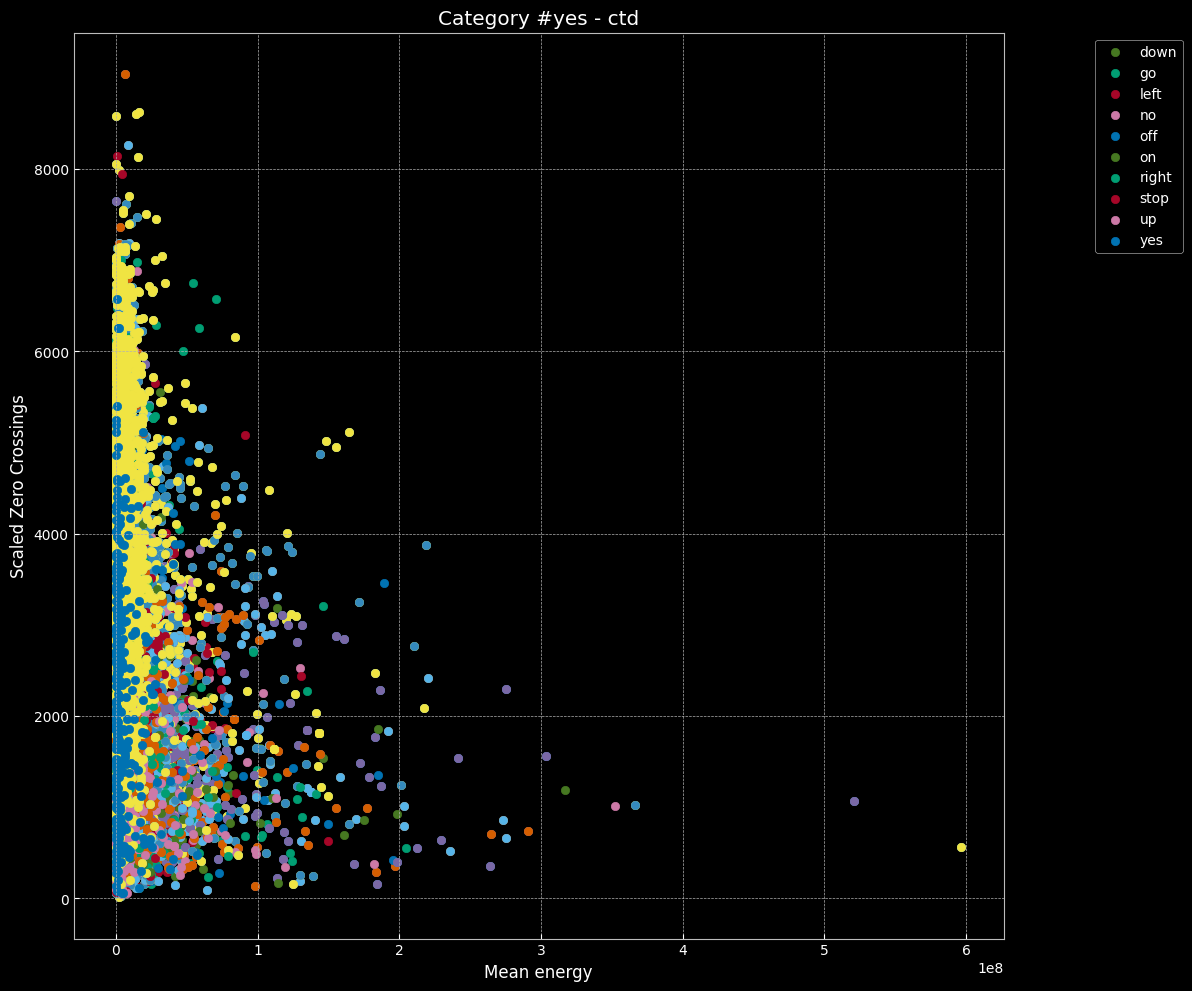

In [63]:
fig = plt.figure(figsize = (12,12))
centered =  input("Would you prefer centered data features? y/n:  ").lower() 



for category in reduced_classes: 
    
    if centered == "y":
        
        plt.scatter(energies_feature_train_centered[category], zc_feature_train_centered[category], label = f"{category}", cmap ="tab32")
        plt.scatter(energies_feature_valid_centered[category], zc_feature_valid_centered[category], label = f"{category}")
        plt.scatter(energies_feature_test_centered[category],  zc_feature_test_centered[category], label = f"{category}")

        plt.scatter(energies_feature_short_centered[category], zc_feature_short_centered[category], label = f"{category}")
        
        plt.xlabel("Mean energy")
        plt.ylabel("Scaled Zero Crossings")
        
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        
        plt.legend(by_label.values(), by_label.keys(), loc = "upper right", bbox_to_anchor=(1.2, 1))
        plt.title(f"Category #{category} - ctd")
    
    else: 
        
        plt.scatter(energies_feature_train[category], zc_feature_train[category], label = f"{category}")
        plt.scatter(energies_feature_valid[category], zc_feature_valid[category], label = f"{category}")
        plt.scatter(energies_feature_test[category],  zc_feature_test[category], label = f"{category}")

        plt.scatter(energies_feature_short[category], zc_feature_short[category], label = f"{category}")
        
        plt.xlabel("Mean energy")
        plt.ylabel("Zero Crossings")
        
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))

        plt.legend(by_label.values(), by_label.keys(), loc = "upper right", bbox_to_anchor=(1.2, 1))
        plt.title(f"Category #{category} - raw")

### Adding random noise to the ones that didn't surpass the sanity check -- STILL TO APPLY

In [35]:
# ds.add_random_noise(REDUCED_DATASET_PATH)

## Saving all dictionaries 

## MFCCs - Feature Extraction 

In this passage we extract the *Mel Cepstral Coefficients Feature* from the audio tracks. This has a twofold explanation. First, our dataset is quite huge (2,3 GiB) the preprocessing phase should be done beforehead to reduce time and computational resources. In particular, with the following function, we proceed by extracting the MFCC representation of our audio data, in a `.json` format.

Secondly, MFCCs capture timbral/textural aspects of sound. So extracting properties such the latter from audio in a visual way allows a great variety of applications (genre recognition, music instrument recognition, ...), given by the expressiveness of this feature representation of the raw data. 

Here below we specify the dataset's path and the destination path of the associated `.json` file. Another constant is the default sample frequency used by the librosa library. 

### Feature Extraction excluding short audio files 

In [13]:
short_audio_samples_reduced =  [file[:-1] for file in open("../documents/short_audio_filenames_reduced.txt", "r").readlines()]

In [9]:
%%time 
dataset_reduced_f = fs.mfcc_feature_extraction(REDUCED_DATASET_PATH, SAMPLES_TO_CONSIDER, JSON_PATH, REDUCED_JSON_NAME, disposal = short_audio_samples, verbosity = 1)

Processing the down category
Processing the go category
Processing the left category
Processing the no category
Processing the off category
Processing the on category
Processing the right category
Processing the stop category
Processing the up category
Processing the yes category
Executed on 2022-05-23
CPU times: total: 6min 34s
Wall time: 6min 16s


From preliminary analyses we've noticed that the number of occurrences that are longer than 1 sec is pretty high for each category. From the following check we can assess that there's no sample that respects the lenght condition. 
We might understand the nature of the dataset then, by location of the signal, the start and the stop for each one in order to understand clearly the real quality of the data at hand. 

In [10]:
dataset_reduced_f["files"][:5], len(dataset_reduced_f["files"])

(['down/00176480_nohash_0.wav',
  'down/004ae714_nohash_0.wav',
  'down/00b01445_nohash_0.wav',
  'down/00b01445_nohash_1.wav',
  'down/00f0204f_nohash_0.wav'],
 34975)

### Extract the encoding 

In [14]:
encoding_reduced_dataset = dataset_reduced_f["encoding"]
encoding_reduced_dataset

{'down': 0,
 'go': 1,
 'left': 2,
 'no': 3,
 'off': 4,
 'on': 5,
 'right': 6,
 'stop': 7,
 'up': 8,
 'yes': 9}

In [ ]:
ds.save_json("../documents/",
             "encoding_reduced_dataset.json",
             encoding_reduced_dataset)

In [8]:
del dataset_reduced_f

### Importing processed dataset from `.json` file

In [ ]:
dataset = ds.import_data_dictionary(JSON_PATH + REDUCED_JSON_NAME) # check the date 

---
## Train-Validation-Test Split 
---

In this part we're going to focus on the train-validation-test split according to the paper _"Speech Commands: A Dataset for Limited-Vocabulary Speech Recognition"_. 

Specifically, in the subsequent part of the notebook we're going to set a data splitting, focusing on the 10 categories of V1 dataset:
```python 
>>>['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']
```
but with the numerosity of the V2 dataset.

### Validation Data

In [22]:
with open(DATA_DOCUMENTATION_PATH + "validation_list.txt", "r") as file:
    validation_data = file.readlines()

In [23]:
lista = [linea for linea in validation_data]
len(set(lista))
    
# 9981

9981

In [24]:
lista[:15]

['right/a69b9b3e_nohash_0.wav\n',
 'right/439c84f4_nohash_1.wav\n',
 'right/409c962a_nohash_1.wav\n',
 'right/dbaf8fc6_nohash_2.wav\n',
 'right/a6d586b7_nohash_1.wav\n',
 'right/0e17f595_nohash_1.wav\n',
 'right/ff2b842e_nohash_3.wav\n',
 'right/7fd25f7c_nohash_2.wav\n',
 'right/3cc595de_nohash_4.wav\n',
 'right/591d32f3_nohash_0.wav\n',
 'right/52bfbce8_nohash_0.wav\n',
 'right/ff2b842e_nohash_2.wav\n',
 'right/7fd25f7c_nohash_3.wav\n',
 'right/0e17f595_nohash_0.wav\n',
 'right/471a0925_nohash_4.wav\n']

In [25]:
validation_list, validation_set = ds.extract_set_list_from_text(DATA_DOCUMENTATION_PATH, 
                                                             "validation_list.txt")

In [26]:
list(validation_set)[:5], len(validation_set), len(validation_list)

(['go/3cc595de_nohash_2.wav',
  'up/f822b9bf_nohash_4.wav',
  'off/55feffd5_nohash_1.wav',
  'go/8dc18a75_nohash_1.wav',
  'right/538e1856_nohash_0.wav'],
 3703,
 3703)

### Testing Data

In [27]:
with open(DATA_DOCUMENTATION_PATH + "testing_list.txt", "r") as file:
    testing_data = file.readlines()

In [28]:
lista = [linea for linea in testing_data]
len(set(lista))
    
# 11005

11005

In [29]:
testing_list, testing_set = ds.extract_set_list_from_text(DATA_DOCUMENTATION_PATH, 
                                                       "testing_list.txt")

In [30]:
list(testing_set)[:5], len(testing_set), len(testing_list)

(['right/b97c9f77_nohash_3.wav',
  'up/7192fddc_nohash_1.wav',
  'off/daf230ac_nohash_1.wav',
  'left/bb05582b_nohash_3.wav',
  'yes/0cb74144_nohash_3.wav'],
 4074,
 4074)

Now we see if there is any intersection between the names included in the `validation_list` and `testing_list`, which should be empty

$${\large \mathcal{V} \cap \mathcal{T} = \emptyset}$$

In [20]:
intersection = testing_set.intersection(validation_set) 
intersection

set()

Before going further, we sum up some important aspects relating to the dimensions of the faced quantities: 

- Training Set $\mathcal{T_R}$ cardinality: 30769
- Validation Set $\mathcal{V}$ cardinality: 3703
- Test Set $\mathcal{T}$ cardinality: 4074
- Total number of observations: 38546
- MFFCs feature dimension: 99 x 40 (coefficients)

We can conclude also that, in order to make the split properly, we should use the lists including the class since it was proven that hash names are repeated across different classes. Anyway, we checked that in the sets containing the unique filenames of both test and validation sets there're no overlapping names.  

In [21]:
del validation_set, testing_set

### Data Splitting 
Here we perform a splitting of the dataset, according to the Pete Warden indications. 

In [14]:
%%time
X_train_reduced, y_train_reduced, X_valid_reduced, y_valid_reduced, X_test_reduced, y_test_reduced, filenames_reduced  = ds.fast_default_data_splitting(data_path = JSON_PATH + REDUCED_JSON_NAME, documentation_path = DATA_DOCUMENTATION_PATH, disposal = short_audio_samples_reduced)

CPU times: total: 1min 44s
Wall time: 1min 44s


In [15]:
# checking dimensions
print("X_train_reduced: ", X_train_reduced.shape,  "\ny_train_reduced: ", y_train_reduced.shape, "\nX_valid_reduced: ", X_valid_reduced.shape, "\ny_valid_reduced: ", y_valid_reduced.shape, "\nX_test_reduced: ", X_test_reduced.shape,  "\ny_test_reduced: ",  y_test_reduced.shape)

X_train_reduced:  (27864, 40, 99) 
y_train_reduced:  (27864,) 
X_valid_reduced:  (3336, 40, 99) 
y_valid_reduced:  (3336,) 
X_test_reduced:  (3775, 40, 99) 
y_test_reduced:  (3775,)


### Saving filenames for splits

In [17]:
textfile_train_reduced, textfile_valid_reduced, textfile_test_reduced = open("../documents/audio_filenames_train_reduced.txt", "w"),  open("../documents/audio_filenames_valid_reduced.txt", "w"), open("../documents/audio_filenames_test_reduced.txt", "w")

for element in filenames_reduced[0]:
    textfile_train_reduced.write(element + "\n")
textfile_train_reduced.close() 

for element in filenames_reduced[1]:
    textfile_valid_reduced.write(element + "\n")
textfile_valid_reduced.close()

for element in filenames_reduced[2]:
    textfile_test_reduced.write(element + "\n")
textfile_test_reduced.close()

### Data Shuffling -- STILL TO APPLY

In [56]:
# X_train, y_train = ds.shuffle(X_train, y_train)
# X_valid, y_valid = ds.shuffle(X_valid, y_valid)
# X_test, y_test = ds.shuffle(X_test, y_test)

In [57]:
# # checking dimensions
# print("X_train: ",  X_train.shape,  
#       "\ny_train: ", y_train.shape, 
#       "\nX_valid: ", X_valid.shape, 
#       "\ny_valid: ", y_valid.shape, 
#       "\nX_test: ",  X_test.shape,  
#       "\ny_test: ",  y_test.shape)

X_train:  (30769, 40, 99) 
y_train:  (30769,) 
X_valid:  (3703, 40, 99) 
y_valid:  (3703,) 
X_test:  (4074, 40, 99) 
y_test:  (4074,)


### Saving binaries

In [68]:
# Save overwrites existent homonym binary files
np.save(BINARIES_PATH + "X_train",  X_train)
np.save(BINARIES_PATH + "X_valid",  X_valid)
np.save(BINARIES_PATH + "X_test",   X_test)

np.save(BINARIES_PATH + "y_train",  y_train)
np.save(BINARIES_PATH + "y_valid",  y_valid)
np.save(BINARIES_PATH + "y_test",   y_test)

### Loading binaries

In [69]:
X_train = np.load(BINARIES_PATH + "X_train.npy")
X_valid = np.load(BINARIES_PATH + "X_valid.npy")
X_test = np.load(BINARIES_PATH + "X_test.npy")

y_train = np.load(BINARIES_PATH + "y_train.npy")
y_valid = np.load(BINARIES_PATH + "y_valid.npy")
y_test = np.load(BINARIES_PATH + "y_test.npy")

### Checking if the sampling was done correctly

Text(0.5, 1.0, 'Test')

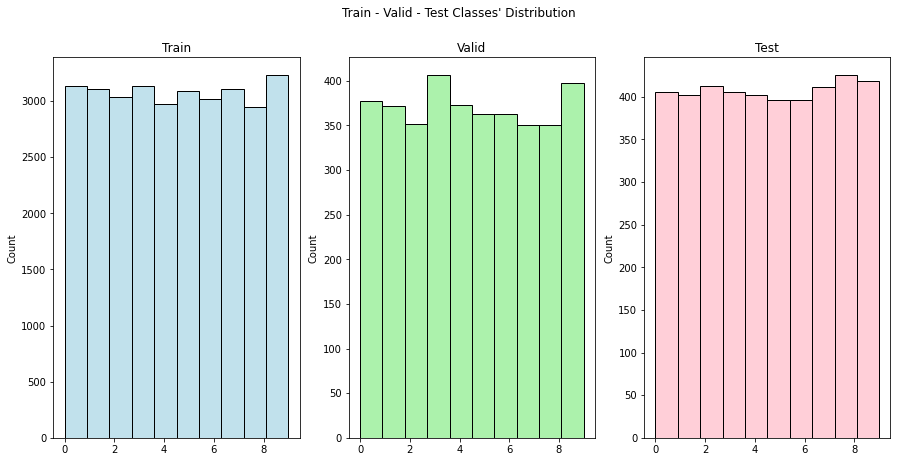

In [70]:
fig, axes = plt.subplots(1, 3, figsize=(15, 7))
fig.suptitle("Train - Valid - Test Classes' Distribution")

sns.histplot(data = y_train, bins = 10, ax = axes[0], color = "lightblue")
axes[0].set_title("Train")

sns.histplot(data = y_valid, bins = 10, ax = axes[1], color = "lightgreen")
axes[1].set_title("Valid")

sns.histplot(data = y_test, bins = 10, ax = axes[2], color = "pink")
axes[2].set_title("Test")

### Observations
---

Between the first sample and the second one we can notice the presence of the same ratio of observation per class among train-valid-test subsets since the principle of selection (even if random) uses the same seed.

## Data Sampling -- TO IGNORE

In [71]:
X_train_sample, y_train_sample = ds.stratified_sampling(X = X_train, y = y_train, num_classes = 10, ratio = 0.4)
X_valid_sample, y_valid_sample = ds.stratified_sampling(X = X_valid, y = y_valid, num_classes = 10, ratio = 0.4)
X_test_sample, y_test_sample = ds.stratified_sampling(X = X_test, y = y_test, num_classes = 10, ratio = 0.4)

Stratified samples of X, y with ratio 0.4 
 original shape 30769 
 sampled shape 12304 
Stratified samples of X, y with ratio 0.4 
 original shape 3703 
 sampled shape 1477 
Stratified samples of X, y with ratio 0.4 
 original shape 4074 
 sampled shape 1625 


## Data Shuffling -- TO IGNORE

In [72]:
X_train_sample, y_train_sample = ds.shuffle(X_train_sample, y_train_sample)
X_valid_sample, y_valid_sample = ds.shuffle(X_valid_sample, y_valid_sample)
X_test_sample, y_test_sample = ds.shuffle(X_test_sample, y_test_sample)

In [73]:
# checking dimensions
print("X_train_sample: ",  X_train_sample.shape,  
      "\ny_train_sample: ", y_train_sample.shape, 
      "\nX_valid_sample: ", X_valid_sample.shape, 
      "\ny_valid_sample: ", y_valid_sample.shape, 
      "\nX_test_sample: ",  X_test_sample.shape,  
      "\ny_test_sample: ",  y_test_sample.shape)

X_train_sample:  (12304, 40, 99) 
y_train_sample:  (12304,) 
X_valid_sample:  (1477, 40, 99) 
y_valid_sample:  (1477,) 
X_test_sample:  (1625, 40, 99) 
y_test_sample:  (1625,)


### Saving binaries

In [74]:
# Save overwrites existent homonym binary files
np.save(BINARIES_PATH + "X_train_sample",  X_train_sample)
np.save(BINARIES_PATH + "X_valid_sample",  X_valid_sample)
np.save(BINARIES_PATH + "X_test_sample",   X_test_sample)

np.save(BINARIES_PATH + "y_train_sample",  y_train_sample)
np.save(BINARIES_PATH + "y_valid_sample",  y_valid_sample)
np.save(BINARIES_PATH + "y_test_sample",   y_test_sample)

### Loading binaries

In [75]:
X_train_sample = np.load(BINARIES_PATH + "X_train_sample.npy")
X_valid_sample = np.load(BINARIES_PATH + "X_valid_sample.npy")
X_test_sample = np.load(BINARIES_PATH + "X_test_sample.npy")

y_train_sample = np.load(BINARIES_PATH + "y_train_sample.npy")
y_valid_sample = np.load(BINARIES_PATH + "y_valid_sample.npy")
y_test_sample = np.load(BINARIES_PATH + "y_test_sample.npy")

### Checking if the sampling was done correctly

Text(0.5, 1.0, 'Test')

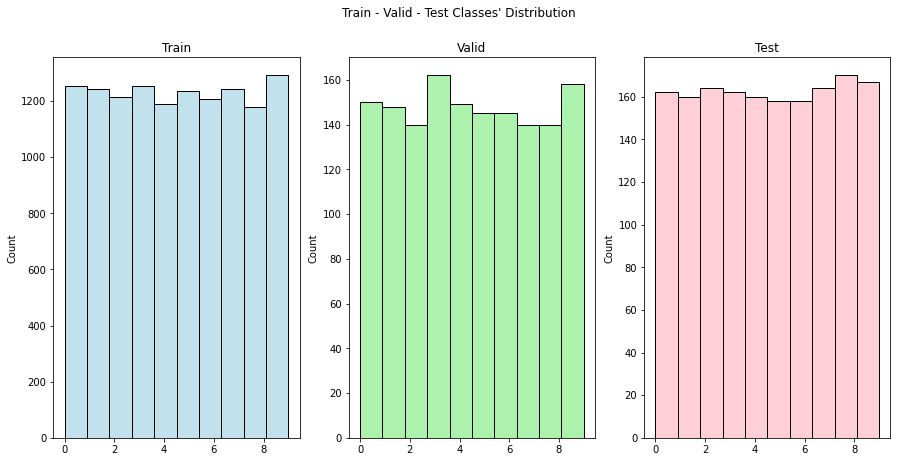

In [76]:
fig, axes = plt.subplots(1, 3, figsize=(15, 7))
fig.suptitle("Train - Valid - Test Classes' Distribution")

sns.histplot(data = y_train_sample, bins = 10, ax = axes[0], color = "lightblue")
axes[0].set_title("Train")

sns.histplot(data = y_valid_sample, bins = 10, ax = axes[1], color = "lightgreen")
axes[1].set_title("Valid")

sns.histplot(data = y_test_sample, bins = 10, ax = axes[2], color = "pink")
axes[2].set_title("Test")

# Delete all variables

In [14]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y
